 # Final Project - Image Classification
 #### Brittany Creel
 #### ADSP 31009 Machine Learning and Predictive Analytics
 #### Spring 2024, Thursdays 6-9 PM

 ### Import Packages and Data, Split the Data into Train/Validation/Test

In [43]:
import os
from os import path
import random
import shutil
from shutil import copyfile
from PIL import Image
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
#connect to Google Drive and change the working directory
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Creel ADSP31009 Final Project'

Mounted at /content/drive
/content/drive/My Drive/Creel ADSP31009 Final Project


In [ ]:
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  []


In [4]:
pwd()

'/content/drive/My Drive/Creel ADSP31009 Final Project'

In [5]:
# Define paths
source_folder = '/content/drive/MyDrive/Creel ADSP31009 Final Project'
train_folder = os.path.join(source_folder, 'train')
test_folder = os.path.join(source_folder, 'test')
val_folder = os.path.join(source_folder, 'val')
real_folder = os.path.join(source_folder, 'RealArt')
ai_folder = os.path.join(source_folder, 'AiArt')
train_real = os.path.join(train_folder, 'real')
train_ai = os.path.join(train_folder, 'ai')
val_real = os.path.join(val_folder, 'real')
val_ai = os.path.join(val_folder, 'ai')
test_real = os.path.join(test_folder, 'real')
test_ai = os.path.join(test_folder, 'ai')

# Create train and test folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(train_real, exist_ok=True)
os.makedirs(train_ai, exist_ok=True)

os.makedirs(test_folder, exist_ok=True)
os.makedirs(test_real, exist_ok=True)
os.makedirs(test_ai, exist_ok=True)

os.makedirs(val_folder, exist_ok=True)
os.makedirs(val_real, exist_ok=True)
os.makedirs(val_ai, exist_ok=True)

# Get lists of images
real_images = os.listdir(real_folder)
ai_images = os.listdir(ai_folder)

 ## Exploratory Data Analysis

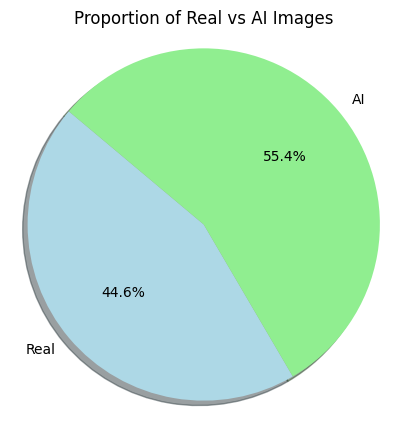

In [6]:
#how many images in each class?
real_count = len(real_images)
ai_count = len(ai_images)
total_count = real_count + ai_count

# Data for the pie chart
pie_labels = ['Real', 'AI']
pie_sizes = [real_count, ai_count]
pie_colors = ['lightblue', 'lightgreen']

# Create the pie chart
plt.figure(figsize=(5, 5))
plt.pie(pie_sizes, labels=pie_labels, colors=pie_colors, autopct='%1.1f%%',
        shadow=True, startangle=140)

plt.title('Proportion of Real vs AI Images')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the pie chart
plt.show()

Examples of Real Images:



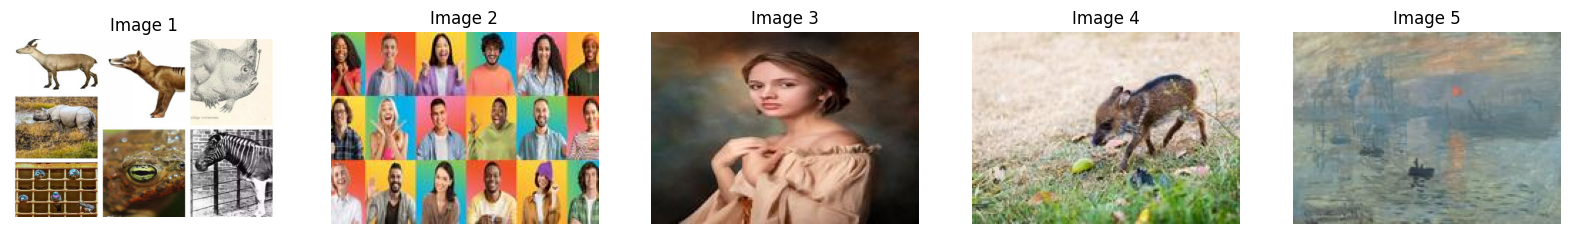

In [7]:
#preview images from each class
print("Examples of Real Images:")
print() #blank space

# Create a figure to display the images
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Loop through the selected images and plot each one
for i, image_name in enumerate(real_images[:5]):
    # Load the image
    img_path = os.path.join(real_folder, image_name)
    img = Image.open(img_path)

    # Display the image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide the axis
    axes[i].set_title(f"Image {i+1}")

# Display the plot
plt.show()

Examples of AI Images:



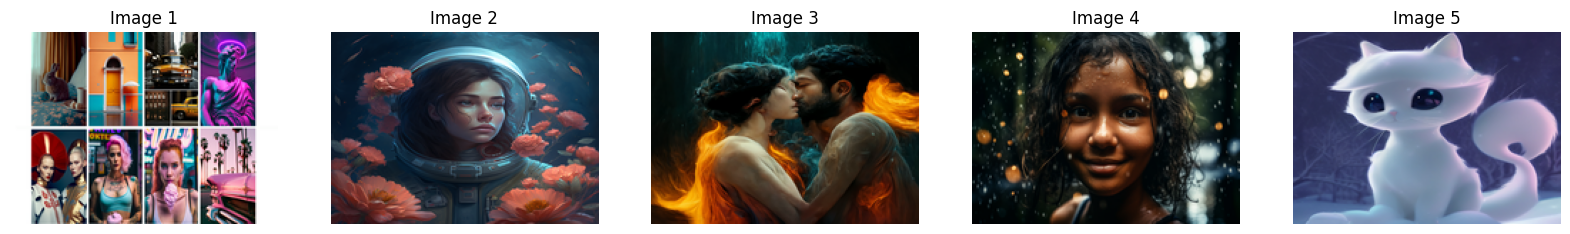

In [8]:
print("Examples of AI Images:")
print() #blank space

# Create a figure to display the images
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Loop through the selected images and plot each one
for i, image_name in enumerate(ai_images[:5]):
    # Load the image
    img_path = os.path.join(ai_folder, image_name)
    img = Image.open(img_path)

    # Display the image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide the axis
    axes[i].set_title(f"Image {i+1}")

# Display the plot
plt.show()

In [9]:
# Initialize a list to store image data
image_sizes = []

# Function to collect image size data
def collect_image_sizes(folder, label):
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        with Image.open(img_path) as img:
            width, height = img.size
            channels = len(img.getbands())
            image_sizes.append({
                'label': label,
                'width': width,
                'height': height,
                'channels': channels
            })

# Collect data for real and AI images
collect_image_sizes(real_folder, 'real')
collect_image_sizes(ai_folder, 'ai')

In [10]:
# Create a DataFrame
size_df = pd.DataFrame(image_sizes)
size_df['pixels'] = size_df['width'] * size_df['height']
size_df['ratio'] = size_df['width']/size_df['height']

# Group by height and width
grouped_size_df = size_df.groupby(['height', 'width']).size().reset_index(name='count')

print(grouped_size_df)

   height  width  count
0     135    188    944
1     499    748      1


In [11]:
#all same channels?
channels_df = size_df.groupby(['channels']).size().reset_index(name='count')
print(channels_df)

   channels  count
0         1      1
1         3    944


In [12]:
#delete images with only 1 channel
def delete_single_channel_images(folder):
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            with Image.open(img_path) as img:
                channels = len(img.getbands())
                if channels == 1:
                    os.remove(img_path)
                    print(f"Deleted {img_path} with {channels} channel(s).")
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# Delete single channel images in real and ai folders
delete_single_channel_images(real_folder)
delete_single_channel_images(ai_folder)

#convert images with 4 channels to have 3
def convert_images_to_3_channels(folder):
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            with Image.open(img_path) as img:
                if len(img.getbands()) == 4:
                    img = img.convert('RGB')  # Convert to RGB, dropping the alpha channel
                    img.save(img_path)
                    print(f"Converted {img_path} from 4 channels to 3 channels.")
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# Convert images in real and ai folders
convert_images_to_3_channels(real_folder)
convert_images_to_3_channels(ai_folder)

#reset real_images and ai_images now that some have been deleted
real_images = os.listdir(real_folder)
ai_images = os.listdir(ai_folder)

#check by re-creating channels_df
collect_image_sizes(real_folder, 'real')
collect_image_sizes(ai_folder, 'ai')
size_df = pd.DataFrame(image_sizes)
size_df['pixels'] = size_df['width'] * size_df['height']
size_df['ratio'] = size_df['width']/size_df['height']
channels_df = size_df.groupby(['channels']).size().reset_index(name='count')
print(channels_df)

Deleted /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/black-american-portraits-130.gif with 1 channel(s).
   channels  count
0         1      1
1         3   1888


In [13]:
#how many unique sizes now?
# Group by height and width
grouped_size_df = size_df.groupby(['height', 'width']).size().reset_index(name='count')
print(grouped_size_df)

#largest image
largest_image = size_df.sort_values(by='pixels', ascending=False).head(1)
print(largest_image)

#smallest image
smallest_image = size_df.sort_values(by='pixels', ascending=True).head(1)
print(smallest_image)

   height  width  count
0     135    188   1887
1     499    748      2
    label  width  height  channels  pixels     ratio
945  real    748     499         3  373252  1.498998
     label  width  height  channels  pixels     ratio
1254  real    188     135         3   25380  1.392593


In [14]:
#average ratio of width to height
print(size_df['ratio'].mean())

1.392705250510432


In [15]:
#make all images the same size
min_height = size_df['height'].min()
min_width = round(min_height * size_df['ratio'].mean())
print("Target size will be height=",min_height,", width=",min_width)

# Function to resize images
def resize_images(folder, min_width, min_height):
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            with Image.open(img_path) as img:
                # Resize image
                resized_img = img.resize((min_width, min_height), Image.ANTIALIAS)
                # Save the resized image back to the same path
                resized_img.save(img_path)
                print(f"Resized {img_path} to {min_width}x{min_height}.")
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# Resize images in real and ai folders
resize_images(real_folder, min_width, min_height)
resize_images(ai_folder, min_width, min_height)

Target size will be height= 135 , width= 188
Error processing /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/1707541234037: unknown file extension: 
Resized /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/AdobeStock_502229899.jpeg to 188x135.
Resized /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/12_20201217171040_10852275_large.jpg to 188x135.
Resized /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/1032249.jpg to 188x135.
Resized /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/1200px-Claude_Monet2C_Impression2C_soleil_levant.jpg to 188x135.
Resized /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/1200x0.jpg to 188x135.
Resized /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/1000_F_553971391_58CnJ3qSdxmrOFUp6eojyVhZ9khKq2Et.jpg to 188x135.
Resized /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/1010172.jpg to 188x135.
Resized /content/drive/MyDrive/Creel ADSP31009 Final Project/Real

<ipython-input-15-c6e7f1b1f068>:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((min_width, min_height), Image.ANTIALIAS)


Resized /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/131207210_web1_20230506dj-littiken-1.jpg to 188x135.
Resized /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/0ogZjy9KvWg2elv-I.jpg to 188x135.
Resized /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/.amazonaws.com2Fpublic2Fimages2Fcb32a00a-bf52-48fe-9ba6-4e21cf4c1c57_800x800.png to 188x135.
Resized /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/172711.jpg to 188x135.
Resized /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/152752.jpg to 188x135.
Resized /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/17042020_beautiful-scenery.jpg to 188x135.
Resized /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/beautiful-nature-mountain-scenery-with-flowers-free-photo.jpg to 188x135.
Resized /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/180222162827-the-kiss-story-top-card-image.jpg to 188x135.
Resized /content/drive/MyDrive/Creel ADSP31009

Review images after transformations

Examples of Real Images:



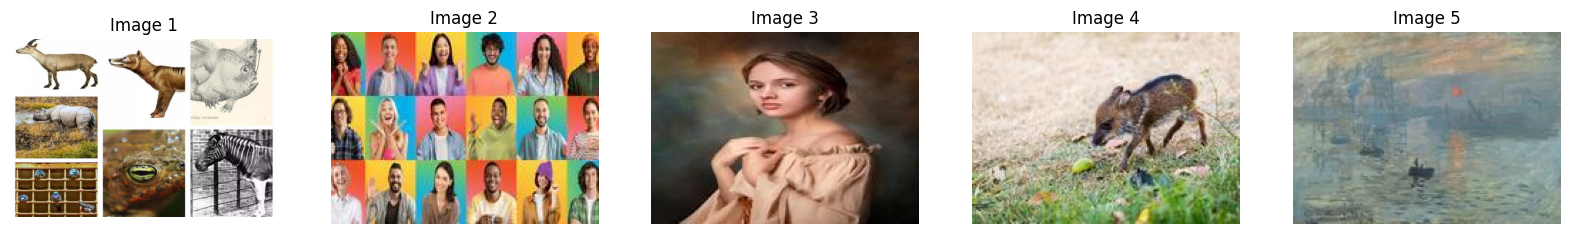

In [16]:
#preview images from each class
print("Examples of Real Images:")
print() #blank space

# Create a figure to display the images
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Loop through the selected images and plot each one
for i, image_name in enumerate(real_images[:5]):
    # Load the image
    img_path = os.path.join(real_folder, image_name)
    img = Image.open(img_path)

    # Display the image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide the axis
    axes[i].set_title(f"Image {i+1}")

# Display the plot
plt.show()

Examples of AI Images:



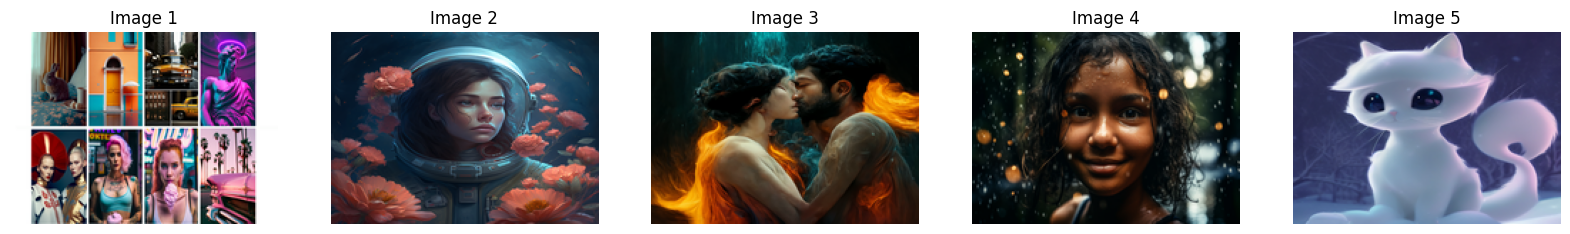

In [17]:
print("Examples of AI Images:")
print() #blank space

# Create a figure to display the images
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Loop through the selected images and plot each one
for i, image_name in enumerate(ai_images[:5]):
    # Load the image
    img_path = os.path.join(ai_folder, image_name)
    img = Image.open(img_path)

    # Display the image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide the axis
    axes[i].set_title(f"Image {i+1}")

# Display the plot
plt.show()

 ## Split the data into train, validation, and test

In [ ]:
# Shuffle the images
random.shuffle(real_images)
random.shuffle(ai_images)

# Define the train-test split ratio
train_split_ratio = 0.7
val_split_ratio = 0.15

# Calculate the number of images for train and test
num_train_real = int(len(real_images) * train_split_ratio)
num_train_ai = int(len(ai_images) * train_split_ratio)
num_val_real = int(len(real_images) * val_split_ratio)
num_val_ai = int(len(ai_images) * val_split_ratio)

# Function to add image data to the list
def add_image_data(image_list, label, image_data):
    for img in image_list:
        image_data.append({'path': os.path.join(source_folder, label, img), 'label': label, 'image': Image.open(os.path.join(source_folder, label, img))})

In [ ]:
# Initialize lists
train_images_list = []
train_images_list_real = []
train_images_list_ai = []
train_image_data = []

# Move real images to train folder
for img in real_images[:num_train_real]:
    src_path = os.path.join(real_folder, img)
    dst_path = os.path.join(train_real, f'real_{img}')
    shutil.copy(src_path, dst_path)
    train_images_list_real.append(dst_path)
    add_image_data(train_images_list_real, 'real', train_image_data)

# Move ai images to train folder
for img in ai_images[:num_train_ai]:
    src_path = os.path.join(ai_folder, img)
    dst_path = os.path.join(train_ai, f'ai_{img}')
    shutil.copy(src_path, dst_path)
    train_images_list_ai.append(dst_path)
    add_image_data(train_images_list_ai, 'ai', train_image_data)

In [ ]:
# Initialize lists
val_images_list = []
val_images_list_real = []
val_images_list_ai = []
val_image_data = []

# Move real images to validation folder
for img in real_images[num_train_real:num_train_real+num_val_real]:
    src_path = os.path.join(real_folder, img)
    dst_path = os.path.join(val_real, f'real_{img}')
    shutil.copy(src_path, dst_path)
    val_images_list_real.append(dst_path)
    add_image_data(val_images_list_real, 'real', val_image_data)

# Move ai images to validation folder
for img in ai_images[num_train_ai:num_train_ai+num_val_ai]:
    src_path = os.path.join(ai_folder, img)
    dst_path = os.path.join(val_ai, f'ai_{img}')
    shutil.copy(src_path, dst_path)
    val_images_list_ai.append(dst_path)
    add_image_data(val_images_list_ai, 'ai', val_image_data)

In [ ]:
# Initialize lists
test_images_list = []
test_images_list_real = []
test_images_list_ai = []
test_image_data = []

# Move remaining real images to test folder
for img in real_images[num_train_real+num_val_real:]:
    src_path = os.path.join(real_folder, img)
    dst_path = os.path.join(test_real, f'real_{img}')
    shutil.copy(src_path, dst_path)
    test_images_list_real.append(dst_path)
    add_image_data(test_images_list_real, 'real', test_image_data)

# Move remaining ai images to test folder
for img in ai_images[num_train_ai+num_val_ai:]:
    src_path = os.path.join(ai_folder, img)
    dst_path = os.path.join(test_ai, f'ai_{img}')
    shutil.copy(src_path, dst_path)
    test_images_list_ai.append(dst_path)
    add_image_data(test_images_list_ai, 'ai', test_image_data)

In [ ]:
# Combine lists
train_images_list = train_images_list_real + train_images_list_ai
val_images_list = val_images_list_real + val_images_list_ai
test_images_list = test_images_list_real + test_images_list_ai

In [ ]:
# Determine how many files are in each folder
train_real_contents = os.listdir(train_real)
train_ai_contents = os.listdir(train_ai)
train_length = len(train_real_contents)+len(train_ai_contents)

val_real_contents = os.listdir(val_real)
val_ai_contents = os.listdir(val_ai)
val_length = len(val_real_contents)+len(val_ai_contents)

test_real_contents = os.listdir(test_real)
test_ai_contents = os.listdir(test_ai)
test_length = len(test_real_contents)+len(test_ai_contents)

In [ ]:
#check
print(f"Number of training images: ",train_length,"(real: ",len(train_real_contents),", ai: ",len(train_ai_contents),") / Number expected: ",num_train_real+num_train_ai,"(real: ",num_train_real,", ai: ",num_train_ai,")")
print(f"Number of validation images: ",val_length,"(real: ",len(val_real_contents),", ai: ",len(val_ai_contents),") / Number expected: ",num_val_real+num_val_ai,"(real: ",num_val_real,", ai: ",num_val_ai,")")
print(f"Number of testing images: ",test_length,"(real: ",len(test_real_contents),", ai: ",len(test_ai_contents),") / Number expected: ",num_val_real+num_val_ai,"(real: ",num_val_real,", ai: ",num_val_ai,")")

Number of training images:  660 (real:  294 , ai:  366 ) / Number expected:  660 (real:  294 , ai:  366 )
Number of validation images:  141 (real:  63 , ai:  78 ) / Number expected:  141 (real:  63 , ai:  78 )
Number of testing images:  144 (real:  64 , ai:  80 ) / Number expected:  141 (real:  63 , ai:  78 )


Note: it is fine test has more than expected because total images - train - validation = remaining all went to test.

 ## Data Processing

In [18]:
#image generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)

In [19]:
train = train_datagen.flow_from_directory(
    directory=train_folder,
    target_size=(min_height, min_width),
    class_mode='categorical',
    batch_size=1,
)

val = val_datagen.flow_from_directory(
    directory=val_folder,
    target_size=(min_height, min_width),
    class_mode='categorical',
    batch_size=1,
)

Found 657 images belonging to 2 classes.
Found 139 images belonging to 2 classes.


In [20]:
# Create an ImageDataGenerator for test data (only rescaling)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Create a generator for loading test images from the test directory
test = test_datagen.flow_from_directory(
    directory=test_folder,
    target_size=(min_height,min_width),
    class_mode='categorical',
    batch_size=1
)

Found 144 images belonging to 2 classes.


In [21]:
train_labels = train.classes
val_labels = val.classes
test_labels = test.classes

 ## Initial Classifier Build

In [22]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(min_height, min_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(2, activation='softmax')
])

Learning Rate: 1e-05
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 133, 186, 32)      896       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 66, 93, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 91, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 32, 45, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_13 (Flatten)        (None, 92160)             0         
                                                                 
 dense_26 (Dense)            (No

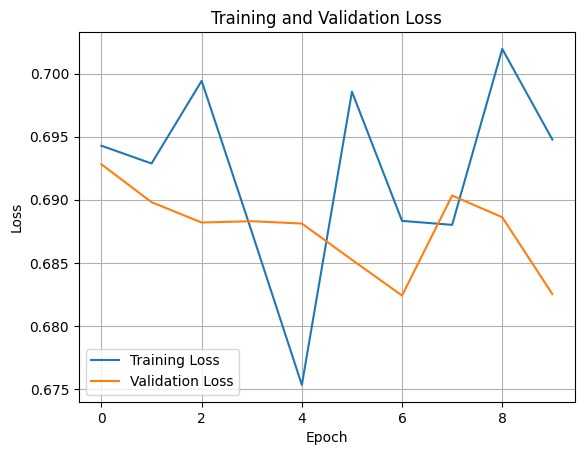

Learning Rate: 0.0001
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 133, 186, 32)      896       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 66, 93, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 91, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 32, 45, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_13 (Flatten)        (None, 92160)             0         
                                                                 
 dense_26 (Dense)            (N

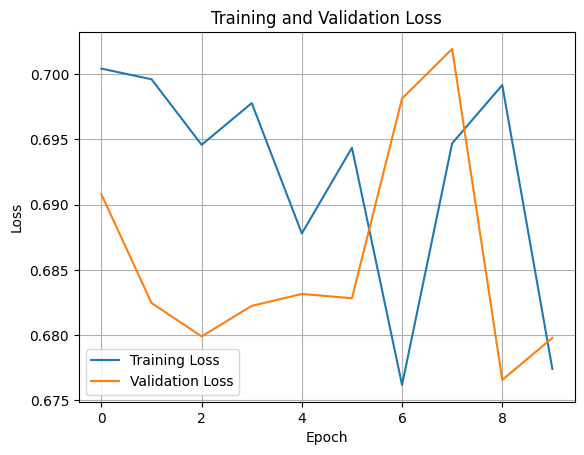

Learning Rate: 0.001
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 133, 186, 32)      896       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 66, 93, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 91, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 32, 45, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_13 (Flatten)        (None, 92160)             0         
                                                                 
 dense_26 (Dense)            (No

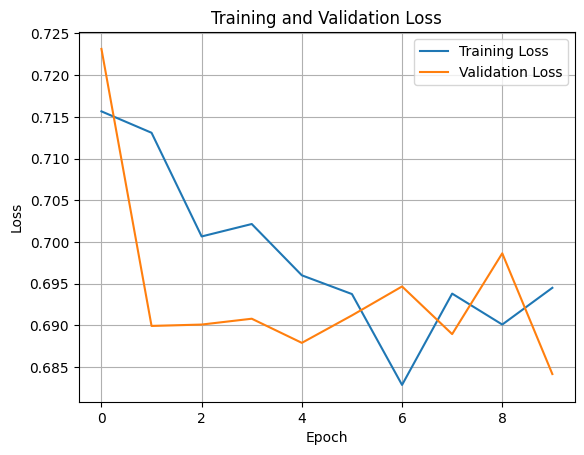

Learning Rate: 0.01
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 133, 186, 32)      896       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 66, 93, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 91, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 32, 45, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_13 (Flatten)        (None, 92160)             0         
                                                                 
 dense_26 (Dense)            (Non

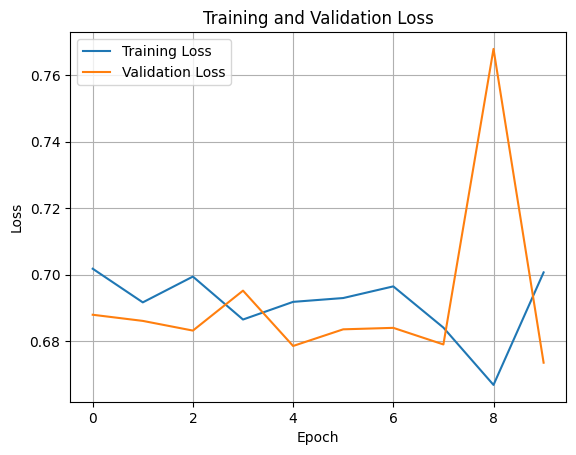

Learning Rate: 0.1
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 133, 186, 32)      896       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 66, 93, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 91, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 32, 45, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_13 (Flatten)        (None, 92160)             0         
                                                                 
 dense_26 (Dense)            (None

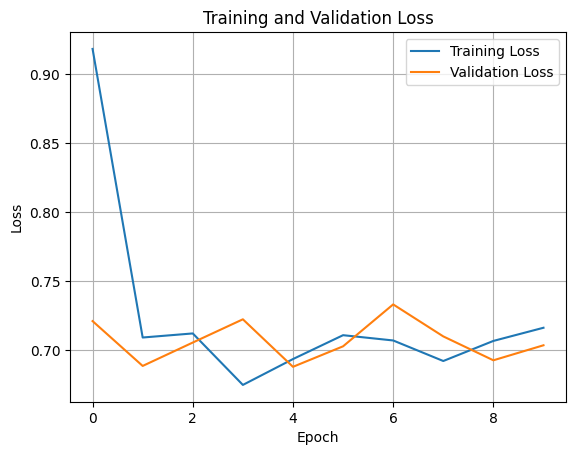

Learning Rate: 1
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 133, 186, 32)      896       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 66, 93, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 91, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 32, 45, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_13 (Flatten)        (None, 92160)             0         
                                                                 
 dense_26 (Dense)            (None, 

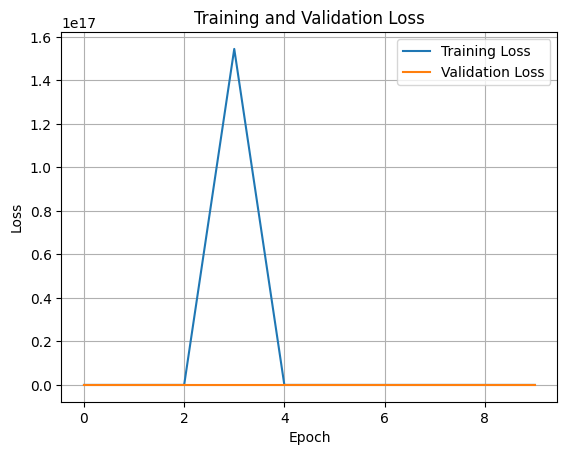

In [85]:
# Compile the model, testing different learning rates
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
for rate in learning_rates:
  print(f"Learning Rate:",rate)
  model.compile(optimizer=SGD(learning_rate=rate), loss='categorical_crossentropy', metrics=['accuracy'])
  print(model.summary())
  #quick test
  history = model.fit(train, epochs=10, steps_per_epoch=100, validation_data=val)
  test_predictions = model.predict(test)
  test_predicted_classes = np.argmax(test_predictions, axis=1)
  print(f"Test Accuracy: ",accuracy_score(test_labels, test_predicted_classes))
  train_predictions = model.predict(train)
  train_predicted_classes = np.argmax(train_predictions, axis=1)
  print(f"Train Accuracy: ",accuracy_score(train_labels, train_predicted_classes))
  print(f"Accuracy Difference: ",train_accuracy - test_accuracy)
  # Plot loss for quick test
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

 ## Model Runs

In [23]:
#compile
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

results = []
#try combinations of steps_per_epoch 10-500 and epochs 1-50
combos = [
    (10, 1, 1),
    (10, 5, 2),
    (10, 10, 3),
    (50, 1, 4),
    (50, 5, 5),
    (50, 10, 6),
    (100, 1, 7),
    (100, 5, 8),
    (100, 10, 9),
    (250, 1, 10),
    (250, 5, 11),
    (250, 10, 12),
    (500, 1, 13),
    (500, 5, 14),
    (500, 10, 15),
]

for steps, epochs, i in combos:
    print(f"Training with steps_per_epoch={steps} and epochs={epochs}")
    history = model.fit(train, epochs=epochs, steps_per_epoch=steps, validation_data=val)
    test_predictions = model.predict(test)
    test_predicted_classes = np.argmax(test_predictions, axis=1)
    test_accuracy = accuracy_score(test_labels, test_predicted_classes)
    train_predictions = model.predict(train)
    train_predicted_classes = np.argmax(train_predictions, axis=1)
    train_accuracy = accuracy_score(train_labels, train_predicted_classes)
    abs_acc_diff = abs(train_accuracy - test_accuracy)
    train_loss = history.history['loss'][0]
    val_loss = history.history['val_loss'][0]
    abs_loss_diff= abs(train_loss - val_loss)
    results.append({
        'Steps_per_epoch': steps,
        'Epochs': epochs,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Absolute Accuracy Difference': abs_acc_diff,
        'Train Loss': train_loss,
        'Validation Loss': val_loss,
        'Absolute Loss Difference': abs_loss_diff
    })

Training with steps_per_epoch=10 and epochs=1
657/657 [==============================] - 102s 155ms/step
Training with steps_per_epoch=10 and epochs=5
Epoch 1/5
10/10 [==============================] - 2s 169ms/step - loss: 0.7798 - accuracy: 0.6000 - val_loss: 0.8151 - val_accuracy: 0.5540
Epoch 2/5
10/10 [==============================] - 2s 176ms/step - loss: 0.8552 - accuracy: 0.6000 - val_loss: 0.7148 - val_accuracy: 0.4460
Epoch 3/5
10/10 [==============================] - 1s 161ms/step - loss: 0.7832 - accuracy: 0.3000 - val_loss: 0.6931 - val_accuracy: 0.5540
Epoch 4/5
10/10 [==============================] - 1s 158ms/step - loss: 0.7229 - accuracy: 0.4000 - val_loss: 0.7084 - val_accuracy: 0.4532
Epoch 5/5
657/657 [==============================] - 7s 11ms/step
Training with steps_per_epoch=10 and epochs=10
Epoch 1/10
10/10 [==============================] - 2s 168ms/step - loss: 0.7166 - accuracy: 0.6000 - val_loss: 0.6990 - val_accuracy: 0.4604
Epoch 2/10
10/10 [============

In [29]:
# Create a DataFrame from the results
results_df = pd.DataFrame(results)
pd.set_option('display.width', 1000)  # Set the display width to prevent wrapping onto new lines

In [30]:
print("Largest Test Accuracy:")
print(results_df.sort_values(by='Test Accuracy', ascending=False).head(1))

Largest Test Accuracy:
   Steps_per_epoch  Epochs  Train Accuracy  Test Accuracy  Absolute Accuracy Difference  Train Loss  Validation Loss  Absolute Loss Difference
3               50       1        0.549467         0.5625                      0.013033    0.705919          0.68743                  0.018488


In [31]:
#Review the results
print("Smallest Difference Between Train and Test Accuracy:")
print(results_df.sort_values(by='Absolute Accuracy Difference').head(1))

Smallest Difference Between Train and Test Accuracy:
    Steps_per_epoch  Epochs  Train Accuracy  Test Accuracy  Absolute Accuracy Difference  Train Loss  Validation Loss  Absolute Loss Difference
11              250      10        0.500761            0.5                      0.000761    0.570237         0.693462                  0.123225


In [32]:
print("Smallest Difference Between Train and Validation Loss:")
print(results_df.sort_values(by='Absolute Loss Difference').head(1))

Smallest Difference Between Train and Validation Loss:
   Steps_per_epoch  Epochs  Train Accuracy  Test Accuracy  Absolute Accuracy Difference  Train Loss  Validation Loss  Absolute Loss Difference
5               50      10        0.546423       0.541667                      0.004756     0.68972         0.686665                  0.003055


In [33]:
print("All Results:")
print(results_df.sort_values(by='Test Accuracy', ascending=False))

All Results:
    Steps_per_epoch  Epochs  Train Accuracy  Test Accuracy  Absolute Accuracy Difference  Train Loss  Validation Loss  Absolute Loss Difference
3                50       1        0.549467       0.562500                      0.013033    0.705919         0.687430                  0.018488
0                10       1        0.554033       0.555556                      0.001522    0.901346         0.771542                  0.129804
5                50      10        0.546423       0.541667                      0.004756    0.689720         0.686665                  0.003055
14              500      10        0.503805       0.527778                      0.023973    0.526639         0.722151                  0.195512
10              250       5        0.525114       0.527778                      0.002664    0.640727         0.689676                  0.048949
8               100      10        0.497717       0.520833                      0.023116    0.663078         0.680036      

In [34]:
#plot loss for best performing models
model2 = model.fit(train, epochs=1, steps_per_epoch=50, validation_data=val) #largest test accuracy
model3 = model.fit(train, epochs=10, steps_per_epoch=250, validation_data=val) #smallest accuracy difference
model4 = model.fit(train, epochs=10, steps_per_epoch=50, validation_data=val) #smallest loss difference

50/50 [==============================] - 6s 127ms/step - loss: 0.4677 - accuracy: 0.7400 - val_loss: 0.8433 - val_accuracy: 0.5683
Epoch 1/10
250/250 [==============================] - 7s 26ms/step - loss: 0.4967 - accuracy: 0.7560 - val_loss: 0.7399 - val_accuracy: 0.5971
Epoch 2/10
250/250 [==============================] - 6s 22ms/step - loss: 0.4546 - accuracy: 0.7880 - val_loss: 0.7293 - val_accuracy: 0.6259
Epoch 3/10
250/250 [==============================] - 6s 23ms/step - loss: 0.4770 - accuracy: 0.7560 - val_loss: 0.8136 - val_accuracy: 0.5396
Epoch 4/10
250/250 [==============================] - 5s 18ms/step - loss: 0.4655 - accuracy: 0.7920 - val_loss: 0.8413 - val_accuracy: 0.6115
Epoch 5/10
250/250 [==============================] - 6s 22ms/step - loss: 0.4512 - accuracy: 0.7640 - val_loss: 0.6661 - val_accuracy: 0.6403
Epoch 6/10
250/250 [==============================] - 6s 22ms/step - loss: 0.4833 - accuracy: 0.7920 - val_loss: 0.7043 - val_accuracy: 0.6043
Epoch 7/10


Epochs:  1  Steps Per Epoch:  50


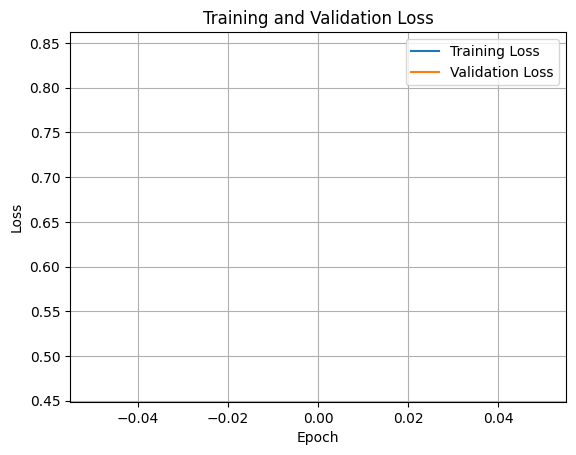

Epochs:  10  Steps Per Epoch:  250


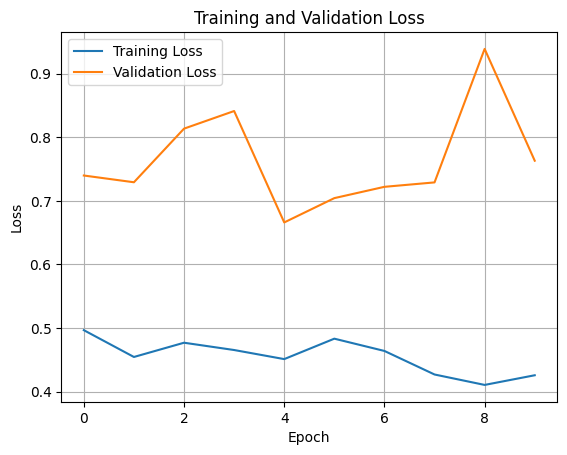

Epochs:  10  Steps Per Epoch:  50


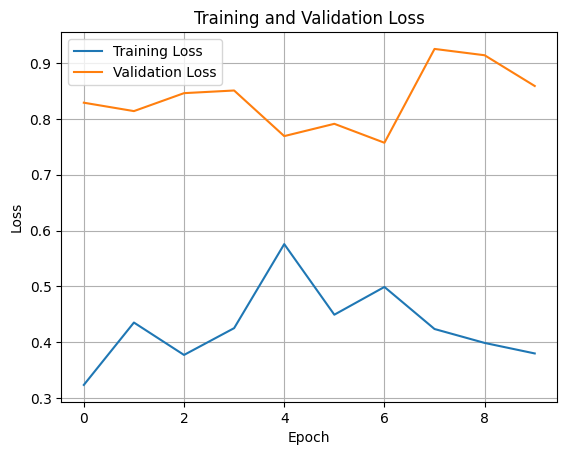

In [38]:
model_list = [model2, model3, model4]
for m in model_list:
  print(f"Epochs: ",m.params['epochs']," Steps Per Epoch: ",m.params['steps'])
  plt.plot(m.history['loss'], label='Training Loss')
  plt.plot(m.history['val_loss'], label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

 ## Determine if Model with Best Performance Improves Further with Early Stopping

In [39]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(min_height, min_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(2, activation='softmax')
])

#compile
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
# Train the model with early stopping
best_earlystop = model.fit(train, epochs=10, steps_per_epoch=250, validation_data=val, callbacks=[early_stopping])

Epoch 1/10
250/250 [==============================] - 9s 34ms/step - loss: 0.6993 - accuracy: 0.5600 - val_loss: 0.6891 - val_accuracy: 0.5540
Epoch 2/10
250/250 [==============================] - 6s 23ms/step - loss: 0.6934 - accuracy: 0.5520 - val_loss: 0.6849 - val_accuracy: 0.5396
Epoch 3/10
250/250 [==============================] - 6s 24ms/step - loss: 0.6810 - accuracy: 0.5920 - val_loss: 0.6851 - val_accuracy: 0.5899
Epoch 4/10
250/250 [==============================] - 6s 24ms/step - loss: 0.6621 - accuracy: 0.6120 - val_loss: 0.6937 - val_accuracy: 0.5180
Epoch 5/10
250/250 [==============================] - 4s 18ms/step - loss: 0.6623 - accuracy: 0.5960 - val_loss: 0.6768 - val_accuracy: 0.5540
Epoch 6/10
250/250 [==============================] - 7s 27ms/step - loss: 0.6643 - accuracy: 0.6120 - val_loss: 0.6765 - val_accuracy: 0.5468


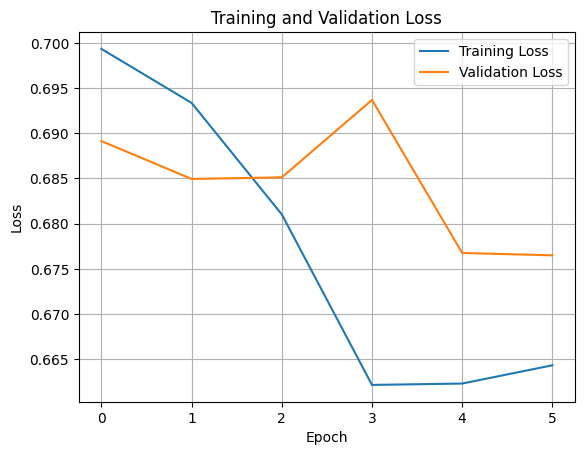

In [40]:
plt.plot(best_earlystop.history['loss'], label='Training Loss')
plt.plot(best_earlystop.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
# Predict using the saved model and the test generator
predictions_earlystop = model.predict(test)

# Convert predictions to class labels
predicted_classes_earlystop = np.argmax(predictions_earlystop, axis=1)

# Print the predicted class labels
print("Predicted class labels:", predicted_classes_earlystop)

#accuracy calc
test_accuracy = accuracy_score(test_labels, predicted_classes_earlystop)
print("Test Accuracy:", test_accuracy)

144/144 [==============================] - 1s 9ms/step
Predicted class labels: [0 0 0 0 1 0 1 1 0 1 1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 1 1 0 0
 1 1 1 1 0 1 0 0 0 1 0 0 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 0 1 1
 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 1 1
 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1 0 0 0 1 0 0]
Test Accuracy: 0.4513888888888889


Test Accuracy much worse with early stopping

What about dropout?

Epoch 1/10
250/250 [==============================] - 10s 30ms/step - loss: 0.7177 - accuracy: 0.5320 - val_loss: 0.6877 - val_accuracy: 0.6187
Epoch 2/10
250/250 [==============================] - 5s 19ms/step - loss: 0.7040 - accuracy: 0.5040 - val_loss: 0.6893 - val_accuracy: 0.6043
Epoch 3/10
250/250 [==============================] - 7s 27ms/step - loss: 0.6904 - accuracy: 0.5600 - val_loss: 0.6906 - val_accuracy: 0.5396
Epoch 4/10
250/250 [==============================] - 5s 18ms/step - loss: 0.6856 - accuracy: 0.5680 - val_loss: 0.6786 - val_accuracy: 0.6259
Epoch 5/10
250/250 [==============================] - 6s 23ms/step - loss: 0.6723 - accuracy: 0.6160 - val_loss: 0.6841 - val_accuracy: 0.5540
Epoch 6/10
250/250 [==============================] - 6s 23ms/step - loss: 0.6753 - accuracy: 0.5520 - val_loss: 0.6712 - val_accuracy: 0.5827
Epoch 7/10
250/250 [==============================] - 7s 27ms/step - loss: 0.6564 - accuracy: 0.6160 - val_loss: 0.6795 - val_accuracy: 0.604

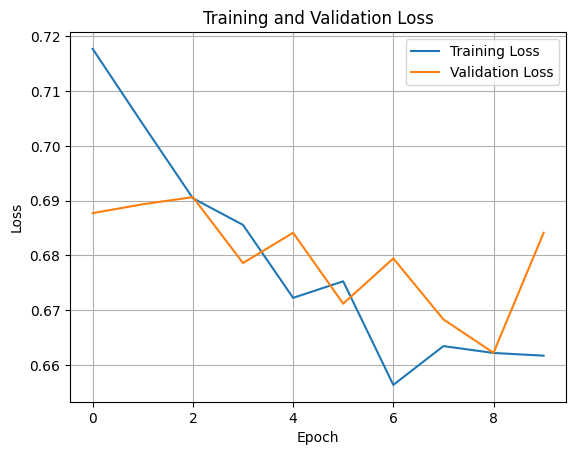

144/144 [==============================] - 1s 5ms/step
Predicted class labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Test Accuracy: 0.5416666666666666


In [44]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(min_height, min_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

#compile
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
best_dropout = model.fit(train, epochs=10, steps_per_epoch=250, validation_data=val)

#plot loss
plt.plot(best_dropout.history['loss'], label='Training Loss')
plt.plot(best_dropout.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Predict using the saved model and the test generator
predictions_dropout = model.predict(test)

# Convert predictions to class labels
predicted_classes_dropout = np.argmax(predictions_dropout, axis=1)

# Print the predicted class labels
print("Predicted class labels:", predicted_classes_dropout)

#accuracy calc
test_accuracy = accuracy_score(test_labels, predicted_classes_dropout)
print("Test Accuracy:", test_accuracy)

This improved test accuracy, but validation loss appears to be going up instead of down at the end. Are there further improvements adjusting epochs again?

Epoch 1/8
250/250 [==============================] - 6s 22ms/step - loss: 0.6164 - accuracy: 0.6600 - val_loss: 0.6545 - val_accuracy: 0.6115
Epoch 2/8
250/250 [==============================] - 4s 17ms/step - loss: 0.6215 - accuracy: 0.6400 - val_loss: 0.6665 - val_accuracy: 0.6043
Epoch 3/8
250/250 [==============================] - 6s 24ms/step - loss: 0.5998 - accuracy: 0.6760 - val_loss: 0.6782 - val_accuracy: 0.5324
Epoch 4/8
250/250 [==============================] - 4s 17ms/step - loss: 0.5924 - accuracy: 0.6600 - val_loss: 0.6765 - val_accuracy: 0.5468
Epoch 5/8
250/250 [==============================] - 6s 25ms/step - loss: 0.5924 - accuracy: 0.6920 - val_loss: 0.6916 - val_accuracy: 0.5755
Epoch 6/8
250/250 [==============================] - 4s 17ms/step - loss: 0.5953 - accuracy: 0.6480 - val_loss: 0.6938 - val_accuracy: 0.6115
Epoch 7/8
250/250 [==============================] - 4s 17ms/step - loss: 0.5919 - accuracy: 0.7080 - val_loss: 0.6790 - val_accuracy: 0.5755
Epoch 

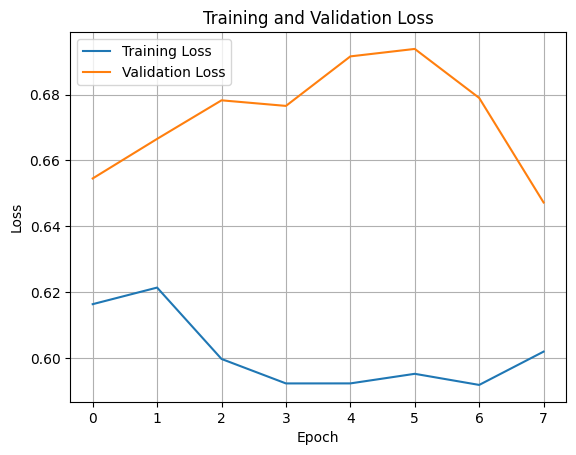

144/144 [==============================] - 1s 4ms/step
Predicted class labels: [1 0 0 1 1 1 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0
 0 0 1 0 1 1 1 0 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 1 1 1 1 0 0 0
 0 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0
 0 0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 0 0 0]
Test Accuracy: 0.4722222222222222


In [46]:
#less epochs
dropout3 = model.fit(train, epochs=8, steps_per_epoch=250, validation_data=val)

#plot loss
plt.plot(dropout3.history['loss'], label='Training Loss')
plt.plot(dropout3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Predict using the saved model and the test generator
predictions_dropout = model.predict(test)

# Convert predictions to class labels
predicted_classes_dropout = np.argmax(predictions_dropout, axis=1)

# Print the predicted class labels
print("Predicted class labels:", predicted_classes_dropout)

#accuracy calc
test_accuracy = accuracy_score(test_labels, predicted_classes_dropout)
print("Test Accuracy:", test_accuracy)

Epoch 1/20
250/250 [==============================] - 6s 26ms/step - loss: 0.6329 - accuracy: 0.6320 - val_loss: 0.6651 - val_accuracy: 0.5755
Epoch 2/20
250/250 [==============================] - 7s 26ms/step - loss: 0.6538 - accuracy: 0.6160 - val_loss: 0.6544 - val_accuracy: 0.5899
Epoch 3/20
250/250 [==============================] - 4s 18ms/step - loss: 0.6524 - accuracy: 0.6400 - val_loss: 0.6627 - val_accuracy: 0.5971
Epoch 4/20
250/250 [==============================] - 6s 24ms/step - loss: 0.6227 - accuracy: 0.6280 - val_loss: 0.6526 - val_accuracy: 0.5683
Epoch 5/20
250/250 [==============================] - 5s 19ms/step - loss: 0.6461 - accuracy: 0.6520 - val_loss: 0.6496 - val_accuracy: 0.6043
Epoch 6/20
250/250 [==============================] - 4s 18ms/step - loss: 0.6442 - accuracy: 0.6280 - val_loss: 0.6908 - val_accuracy: 0.5540
Epoch 7/20
250/250 [==============================] - 7s 27ms/step - loss: 0.6403 - accuracy: 0.6560 - val_loss: 0.7080 - val_accuracy: 0.5612

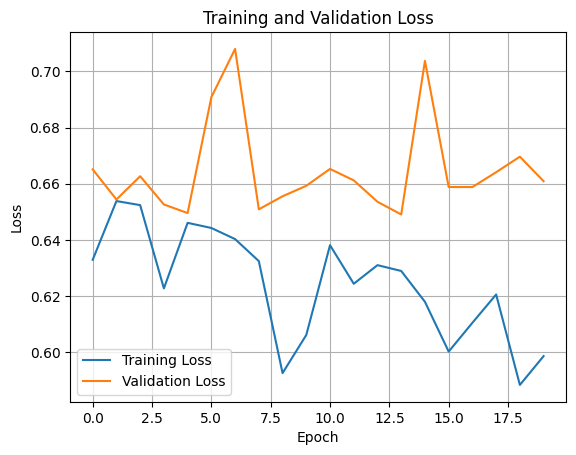

144/144 [==============================] - 1s 4ms/step
Predicted class labels: [0 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0
 0 0 1 0 1 1 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 0 1 0
 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
Test Accuracy: 0.4166666666666667


In [45]:
#more epochs
dropout2 = model.fit(train, epochs=20, steps_per_epoch=250, validation_data=val)

#plot loss
plt.plot(dropout2.history['loss'], label='Training Loss')
plt.plot(dropout2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Predict using the saved model and the test generator
predictions_dropout = model.predict(test)

# Convert predictions to class labels
predicted_classes_dropout = np.argmax(predictions_dropout, axis=1)

# Print the predicted class labels
print("Predicted class labels:", predicted_classes_dropout)

#accuracy calc
test_accuracy = accuracy_score(test_labels, predicted_classes_dropout)
print("Test Accuracy:", test_accuracy)

Epoch 1/15
250/250 [==============================] - 8s 30ms/step - loss: 0.5952 - accuracy: 0.6680 - val_loss: 0.6741 - val_accuracy: 0.5899
Epoch 2/15
250/250 [==============================] - 6s 25ms/step - loss: 0.5923 - accuracy: 0.7120 - val_loss: 0.7221 - val_accuracy: 0.6043
Epoch 3/15
250/250 [==============================] - 4s 17ms/step - loss: 0.6231 - accuracy: 0.6480 - val_loss: 0.6789 - val_accuracy: 0.5827
Epoch 4/15
250/250 [==============================] - 5s 21ms/step - loss: 0.5832 - accuracy: 0.6920 - val_loss: 0.6881 - val_accuracy: 0.5827
Epoch 5/15
250/250 [==============================] - 4s 17ms/step - loss: 0.5579 - accuracy: 0.7040 - val_loss: 0.6918 - val_accuracy: 0.6043
Epoch 6/15
250/250 [==============================] - 7s 27ms/step - loss: 0.5948 - accuracy: 0.7360 - val_loss: 0.6983 - val_accuracy: 0.5971
Epoch 7/15
250/250 [==============================] - 4s 17ms/step - loss: 0.5578 - accuracy: 0.7120 - val_loss: 0.6804 - val_accuracy: 0.5827

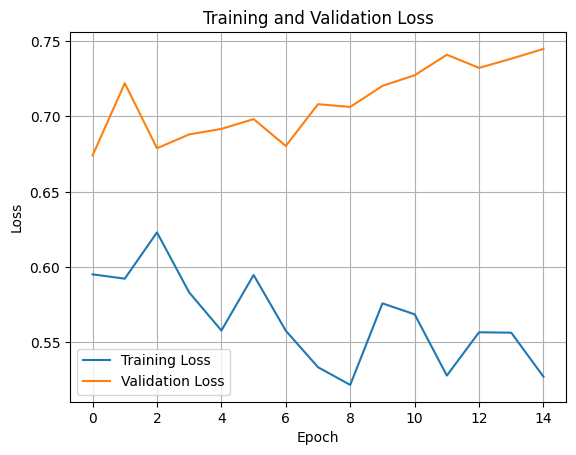

144/144 [==============================] - 1s 6ms/step
Predicted class labels: [0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0
 1 0 1 0 0 1 1 0 1 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0
 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0 1 1 0 0 0 1 1]
Test Accuracy: 0.5138888888888888


In [47]:
#in the middle
dropout4 = model.fit(train, epochs=15, steps_per_epoch=250, validation_data=val)

#plot loss
plt.plot(dropout4.history['loss'], label='Training Loss')
plt.plot(dropout4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Predict using the saved model and the test generator
predictions_dropout = model.predict(test)

# Convert predictions to class labels
predicted_classes_dropout = np.argmax(predictions_dropout, axis=1)

# Print the predicted class labels
print("Predicted class labels:", predicted_classes_dropout)

#accuracy calc
test_accuracy = accuracy_score(test_labels, predicted_classes_dropout)
print("Test Accuracy:", test_accuracy)

Epoch 1/12
250/250 [==============================] - 7s 28ms/step - loss: 0.5192 - accuracy: 0.7600 - val_loss: 0.7385 - val_accuracy: 0.5683
Epoch 2/12
250/250 [==============================] - 6s 26ms/step - loss: 0.5395 - accuracy: 0.7600 - val_loss: 0.7943 - val_accuracy: 0.5540
Epoch 3/12
250/250 [==============================] - 5s 22ms/step - loss: 0.5502 - accuracy: 0.7160 - val_loss: 0.7469 - val_accuracy: 0.5324
Epoch 4/12
250/250 [==============================] - 5s 21ms/step - loss: 0.5805 - accuracy: 0.7000 - val_loss: 0.7069 - val_accuracy: 0.5324
Epoch 5/12
250/250 [==============================] - 4s 17ms/step - loss: 0.4973 - accuracy: 0.7800 - val_loss: 0.7626 - val_accuracy: 0.5827
Epoch 6/12
250/250 [==============================] - 6s 25ms/step - loss: 0.5270 - accuracy: 0.7840 - val_loss: 0.7852 - val_accuracy: 0.5755
Epoch 7/12
250/250 [==============================] - 4s 17ms/step - loss: 0.5685 - accuracy: 0.6880 - val_loss: 0.7447 - val_accuracy: 0.5971

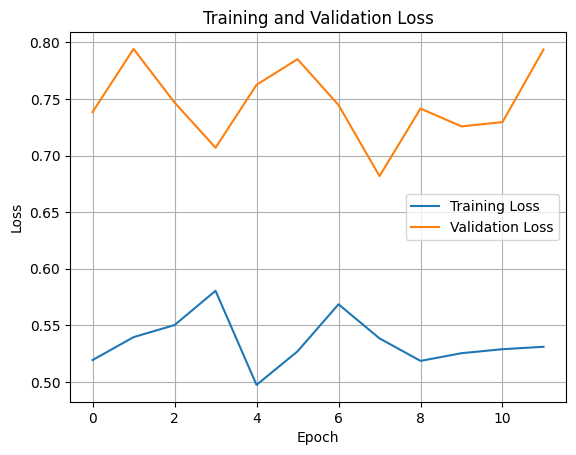

144/144 [==============================] - 1s 8ms/step
Predicted class labels: [1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0
 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 0 0 0
 0 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 0 0 1 0 0 0 1
 0 0 1 0 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0]
Test Accuracy: 0.5277777777777778


In [48]:
dropout5 = model.fit(train, epochs=12, steps_per_epoch=250, validation_data=val)

#plot loss
plt.plot(dropout5.history['loss'], label='Training Loss')
plt.plot(dropout5.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Predict using the saved model and the test generator
predictions_dropout = model.predict(test)

# Convert predictions to class labels
predicted_classes_dropout = np.argmax(predictions_dropout, axis=1)

# Print the predicted class labels
print("Predicted class labels:", predicted_classes_dropout)

#accuracy calc
test_accuracy = accuracy_score(test_labels, predicted_classes_dropout)
print("Test Accuracy:", test_accuracy)

Considering the following the winning model to test on a larger dataset:

In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(min_height, min_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

#compile
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
best_dropout = model.fit(train, epochs=10, steps_per_epoch=250, validation_data=val)

#plot loss
plt.plot(best_dropout.history['loss'], label='Training Loss')
plt.plot(best_dropout.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Predict using the saved model and the test generator
predictions_dropout = model.predict(test)

# Convert predictions to class labels
predicted_classes_dropout = np.argmax(predictions_dropout, axis=1)

# Print the predicted class labels
print("Predicted class labels:", predicted_classes_dropout)

#accuracy calc
test_accuracy = accuracy_score(test_labels, predicted_classes_dropout)
print("Test Accuracy:", test_accuracy)